## LLM

In [73]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from src.tokenizer import TokenizerChar, TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
from src.transformer import *

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [74]:
import os

def read_first_n(directory_path, n):
    # List all entries in the directory
    filenames = os.listdir(directory_path)
    # Filter to only .txt files
    txt_files = [f for f in filenames if f.lower().endswith('.story')]
    # Sort alphabetically (or by any other criteria you like)
    #txt_files.sort()
    # Take the first n
    first_n = txt_files[:n]
    
    contents = []
    for fname in first_n:
        full_path = os.path.join(directory_path, fname)
        with open(full_path, 'r', encoding='utf-8') as f:
            contents.append(normalize_to_ascii(f.read()))
    return contents


In [89]:
corpus = read_first_n('corpus/stories', 100)

In [90]:
tokenizer = TokenizerBPE(corpus, num_merges = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

## Define Model

In [91]:
np.random.seed(42)
tf.random.set_seed(42)

embed_dim = 500
heads = 5
max_seq_len = 100

key_dim = 100

ffnn_dims = [500, 500]
unembed_dims = [250]

transformer = Transformer(vocab_size=tokenizer.vocab_size,
                          max_seq_len=max_seq_len,
                          embed_dim=embed_dim,
                          heads=heads,
                          key_dim=key_dim,
                          ffnn_dims=ffnn_dims,
                          unembed_dims=unembed_dims,
                          lr=0.0005)

losses_train = []
losses_test = []


In [92]:
corpus_indicies = [tf.expand_dims(tokenizer.tokenize(line), axis=0) for line in corpus]

In [93]:
def sample_batch(contents, 
                 batch_size, 
                 tokenizer, 
                 max_seq_len):
    
    samples = len(contents)
    indicies_list = []
    for b in range(batch_size):
        
        idx = np.random.randint(0, samples)
        text = contents[idx]
        length = text.shape[1]
        if length < max_seq_len:
            continue
        else:
            start = np.random.randint(0, length - max_seq_len)
            indicies = text[:,start:start + max_seq_len]
            indicies_list.append(indicies)
    
    indicies_list = tf.concat(indicies_list, axis=0)
    y_true = tf.one_hot(indicies_list, depth=tokenizer.vocab_size)
    y_true = tf.cast(y_true, tf.float32)

    return indicies_list, y_true

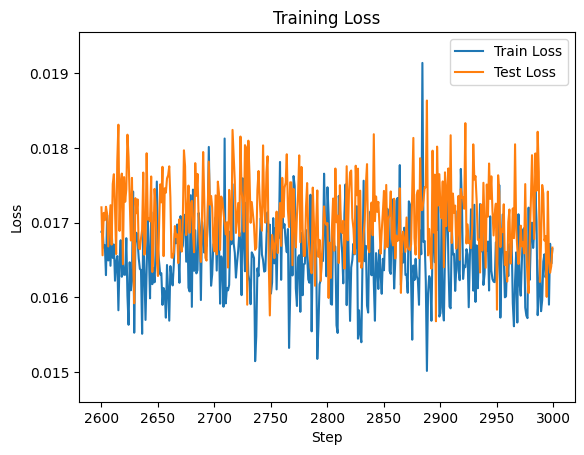

In [108]:
batch_size = 4

for i in tqdm(range(1000)):
    indices, y_true = sample_batch(corpus_indicies[:80], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    

    loss_train = transformer.train_step(indices, y_true)
    losses_train.append(loss_train)

    indices, y_true = sample_batch(corpus_indicies[80:], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    loss_test = transformer.evaluate(indices, y_true)
    losses_test.append(loss_test)

    
    clear_output(wait=True)
    x = np.arange(max(0, len(losses_train)-400), len(losses_train))
    plt.plot(x, losses_train[-400:], label="Train Loss")
    plt.plot(x, losses_test[-400:], label="Test Loss")

    Min = np.min(losses_train[-400:])
    Max = np.max(losses_train[-400:])
    delta = Max - Min
    plt.ylim(Min - delta*0.1, Max + delta*0.1)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

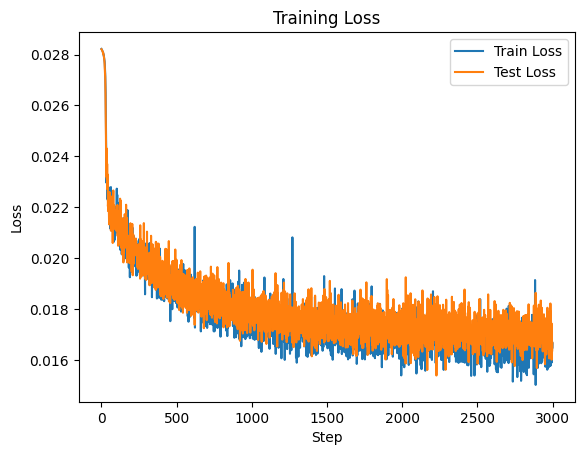

In [109]:
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [96]:
print(corpus[0])

It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria.

Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons.

The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."

It's a step that is set to turn an international crisis into a fierce domestic political battle.

There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react?

In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but because he wa

In [110]:
text = "Obama's remarks came"
indices = tf.expand_dims(tokenizer.tokenize(text), axis=0)
print(indices)

tf.Tensor([[ 43  59 123  58 125   1  91  70  98  68  76   1  60 123  62]], shape=(1, 15), dtype=int32)


In [111]:
for i in range(128):
    y_pred = transformer.pred(indices)
    argmax = tf.cast(tf.argmax(y_pred[:, -2:-1], axis=-1), dtype=tf.int32)
    indices = tf.concat([indices, argmax], axis=1)
    text_pred = tokenizer.detokenize(indices)
    
    print(text_pred.numpy()[0].decode("utf-8"), end='\r', flush=True)
    time.sleep(0.05)


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:AddV2]

In [112]:
indices

<tf.Tensor: shape=(1, 101), dtype=int32, numpy=
array([[ 43,  59, 123,  58, 125,   1,  91,  70,  98,  68,  76,   1,  60,
        123,  62,  73,   1,  73,  90,  73,   1,  73,  90,  73,   1,  73,
         90,  73,   1,  73,  90,  73,   1,  73,  90,  73,   1,   1,  90,
         90,   1,   1,  90,  90,   1,   1,  90,  90,   1,   1,  90,  90,
          1,   1,  90,  90,   1,   1,  90,  90,   1,   1,  90,  90,   1,
          1,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,
         73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,  73,
         73,  73,  73,  73,  73,  73,  73,  73,  73,  73]])>

## 